# IMPORTAR LIBRERIAS

In [40]:
#Si queremos que las imágenes sean mostradas en una ventana emergente quitar el inline
%matplotlib inline  
#%matplotlib qt
# OpenCV-Python utiliza NumPy para el manejo de imágenes
import numpy as np
# cv2 es el módulo python para acceder a OpenCV 
import cv2 as cv
# Usamos las poderosas herramientas de graficación de matplotlib para mostrar imágenes, perfiles, histogramas, etc
import matplotlib.pyplot as plt

# IMAGEN ORIGINAL

In [41]:
Messi = cv.imread('..\Material_TPs\TP2\Messi.jpg', cv.IMREAD_GRAYSCALE)
Messi.shape

(569, 624)

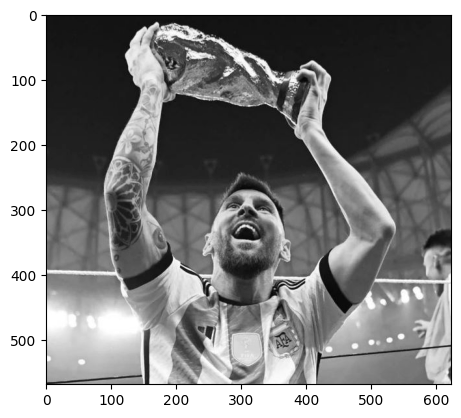

In [42]:
plt.figure()
plt.imshow(Messi, cmap='gray')
plt.show()

# DEFINICION DEL FILTRO GAUSSIANO

In [43]:
def create_gauss_filter (h, w, k_size, sigma):

    # Creacion del kernel gaussiano
    nucleo_g = cv.getGaussianKernel(ksize=k_size, sigma=sigma)
    kernel = nucleo_g * nucleo_g.T

    # Agregado de Padding

    if (h - k_size) % 2 == 0:
        h1 = h2 = int((h - k_size) / 2)
    else:
        h1 = int((h - k_size + 1) / 2)
        h2 = int((h - k_size - 1) / 2)

    if (w - k_size) % 2 == 0:
        w1 = w2 = int((w - k_size) / 2)
    else:
        w1 = int((w - k_size + 1) / 2)
        w2 = int((w - k_size - 1) / 2)

    pad =   ((h1, h2),      # Pad superior e inferior
            (w1, w2))       # Pad iquierda y derecha
    
    kernel = np.pad(kernel, pad_width=pad)
    #print ("Tamaño del kernel: ", kernel.shape)

    # Transformada de Fourier del kernel
    fft = np.fft.fft2(kernel)

    return kernel, fft

# METRICAS DE DESENFOQUE

## Image Sharpness Measure

In [44]:
def Image_Sharpness_Measure(imagen: np.ndarray):
    """
    Descripcion:
        La técnica propuesta consiste en calcular el valor absoluto de la transformada de Fourier
        centrada de la imagen y encontrar el valor máximo de la componente de frecuencia.

        Luego se fija un valor umbral para los componentes de alta frecuencia y se calcula el
        número de componentes de alta frecuencia por encima del umbral para determinar la puntuación
        de calidad de la imagen.

    Args:
        imagen (np.ndarray): Imagen a Procesar

    Returns:
        Float: Medida de calidad de imagen (FM) donde FM significa
        Medida de Difuminación de Imagen en el Dominio de Frecuencia.
    """

    # Paso 1 - Calcular F, que es la Fft de la imagen.
    F = np.fft.fft2(imagen)

    # Paso 2 - Encontrar Fc, que se obtiene desplazando el origen de F al centro.
    Fc = np.fft.fftshift(F)

    # Paso 3 - Calcular AF, que es el valor absoluto de Fc.
    AF = np.abs(Fc)

    # Paso 4 - Obtener Max_AF, que es el valor máximo de AF.
    Max_AF = np.max(AF)

    # Paso 5 - Calcular Th, que es el número total de píxeles en F cuyo valor de píxel > umbral (M/1000).
    Th = np.sum(F > (Max_AF/1000))

    # Paso 6 - Calcular FM, dada por: FM = Th / (M x N), donde M y N son las filas y columnas de la imagen.
    
    M = imagen.shape[0]
    N = imagen.shape[1]

    FM = Th / (M * N)

    print("Metricas de FM: ", FM)

    return FM

## A.15 Tenengrad (GRA6)

In [45]:
def Tenengrad(imagen: np.ndarray):
    """
    Descripcion:
        Una medida de enfoque popular basada en la magnitud del gradiente de la imagen
        se define como la sumatoria de los cuadrados de los gradientes de la imagen en
        las direcciones X e Y.

        Dichos gradientes son calculados mediante la convolución de la imagen dada
        con los operadores Sobel.

        La idea detrás de esta métrica es que los bordes y detalles nítidos en una imagen
        tendrán gradientes más pronunciados, y elevar al cuadrado estos gradientes resaltará
        aún más las áreas enfocadas.

        Cuanto mayor sea la suma, mayor será la presencia de bordes y detalles nítidos,
        lo que podría indicar un mayor enfoque.

    Args:
        imagen (np.ndarray): Imagen a Procesar

    Returns:
        Float: Metrica de enfoque
    """

    # Calcula el gradiente de la imagen
    gradiente_x = cv.Sobel(imagen, cv.CV_64F, 1, 0, ksize=3)
    gradiente_y = cv.Sobel(imagen, cv.CV_64F, 0, 1, ksize=3)

    # Calcula el índice de enfoque
    enfoque = np.sum(gradiente_x ** 2 + gradiente_y ** 2)

    print("Metricas de Tenegrad: ", enfoque)

    return enfoque

## A.24 Gray-level Variance (STA3)

In [46]:
def Gray_level_variance(imagen: np.ndarray):
    """
    Descripcion:
        Esta función calcula la varianza de una imagen para utilizarla como
        medida de desenfoque.

        Se utiliza principalmente para medir contraste, sin embargo una varianza alta
        puede significar un mejor enfoque.

        Se calcula de forma Automatica y manual para comparar resultados.

    Args:
        imagen (np.ndarray): Imagen a Procesar

    Returns:
        tuple: Una tupla que contiene los siguientes valores:
            - Float: Varianza calculada de forma automatica.
            - Float: Varianza calculada de forma manual.
    """

    # Calcular la varianza mediante Numpy
    Varianza_Np = np.var(imagen)

    # Calcular la media de niveles de gris
    media = np.mean(imagen)

    # Calcular la varianza manualmente
    Varianza = sum(sum((imagen - media) ** 2)) / (imagen.shape[0] * imagen.shape[1])

    print("Metricas de GLV: ", Varianza, " - ", Varianza_Np, "\n")

    return Varianza_Np, Varianza

## Funcion para imprimir metricas

In [47]:
def Metricas(Imagen, k_size, sigma):
    print(f"Metricas para k_size = {k_size} y sigma = {sigma}")
    Image_Sharpness_Measure(Imagen)
    Tenengrad(Imagen)
    Gray_level_variance(Imagen)

    return None

# FILTROS EN EL DOMINIO ESPECTRAL

In [48]:
def Aplicar_filtro (imagen, fft):    
    # Calcula la transformada de Fourier 2D de la imagen
    fft_imagen = np.fft.fft2(imagen)

    # Aplica la convolución en el dominio de la frecuencia
    fft_resultado = fft_imagen * fft

    # Calcula la transformada inversa de Fourier para obtener la imagen filtrada
    resultado = np.fft.ifftshift(np.fft.ifft2(fft_resultado).real)

    # llevo la baja frec al origen para acomodar la visualizacion
    fft_imagen_plt = np.fft.fftshift(fft_resultado)
    # obtengo el modulo
    fft_imagen_plt = 20*np.log(np.abs(fft_imagen_plt))

    return fft_imagen_plt, resultado

def graficar(fft_imagen_plt, resultado):
    plt.figure(figsize=(12,12))
    plt.subplot(1,2,1)
    plt.imshow(resultado, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(fft_imagen_plt, cmap='jet')
    
    return None

def Filtrar_imagen(imagen, k_size, sigma):
    kernel, fft = create_gauss_filter(569, 624, k_size, sigma)
    fft_imagen_plt, resultado = Aplicar_filtro(imagen, fft)
    graficar(fft_imagen_plt, resultado)
    Metricas(resultado, k_size, sigma)

    return None

# Punto 1 - GRAFICAR REPRESENTACIONES

## Sigma Fijo

Metricas para k_size = 5 y sigma = 5
Metricas de FM:  0.006334212067955478
Metricas de Tenegrad:  1860542203.1303937
Metricas de GLV:  4515.504004848288  -  4515.504004848284 

Metricas para k_size = 15 y sigma = 5
Metricas de FM:  0.0027573115226893785
Metricas de Tenegrad:  509906230.4973162
Metricas de GLV:  3976.8783107412773  -  3976.8783107412746 

Metricas para k_size = 35 y sigma = 5
Metricas de FM:  0.0021714884412599705
Metricas de Tenegrad:  345712914.20441955
Metricas de GLV:  3773.128757613529  -  3773.1287576135273 

Metricas para k_size = 55 y sigma = 5
Metricas de FM:  0.0021714884412599705
Metricas de Tenegrad:  345145408.9497009
Metricas de GLV:  3771.622073206564  -  3771.6220732065613 



C:\Users\alba_\AppData\Local\Temp\ipykernel_9244\686899201.py:14: RuntimeWarning: divide by zero encountered in log
  fft_imagen_plt = 20*np.log(np.abs(fft_imagen_plt))


Metricas para k_size = 75 y sigma = 5
Metricas de FM:  0.0021714884412599705
Metricas de Tenegrad:  345145364.74569815
Metricas de GLV:  3771.6218925852277  -  3771.6218925852263 



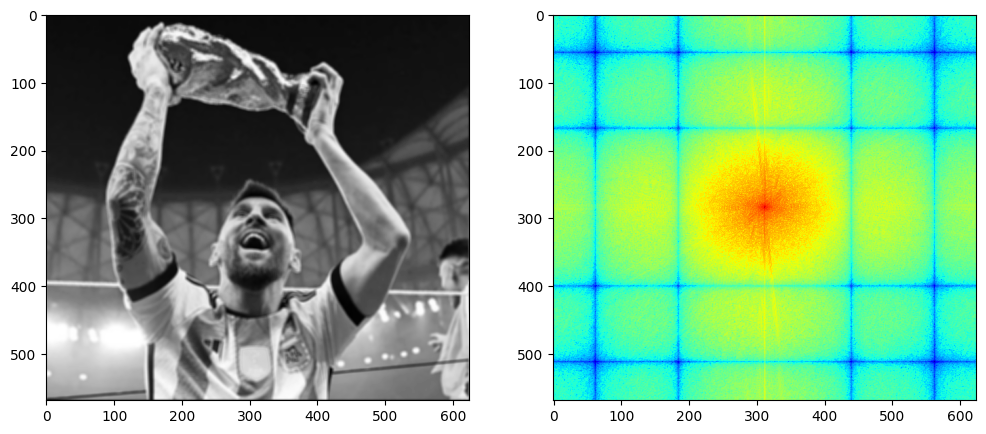

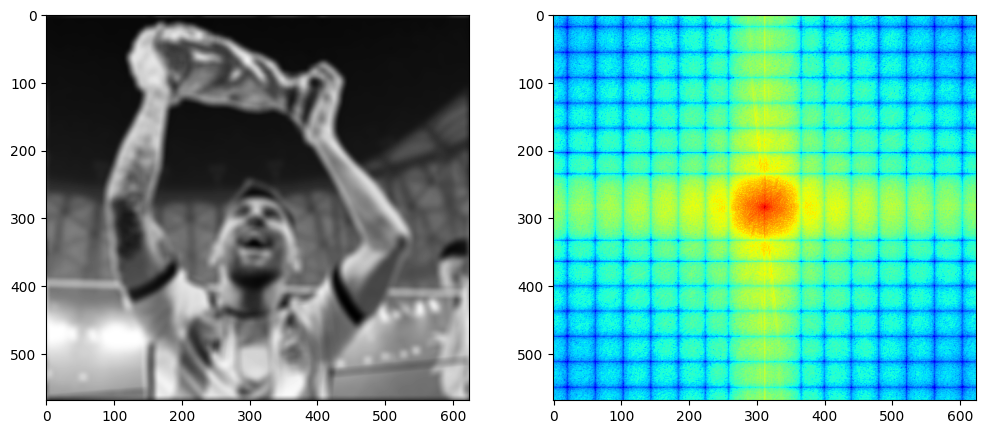

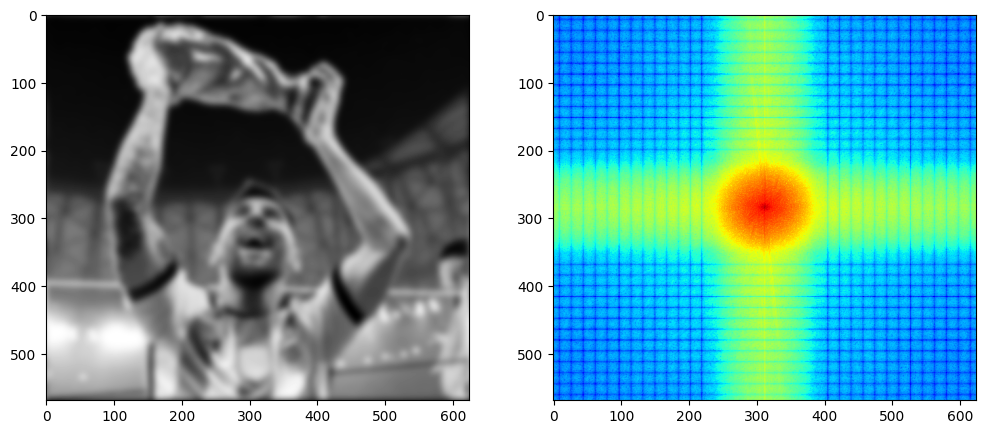

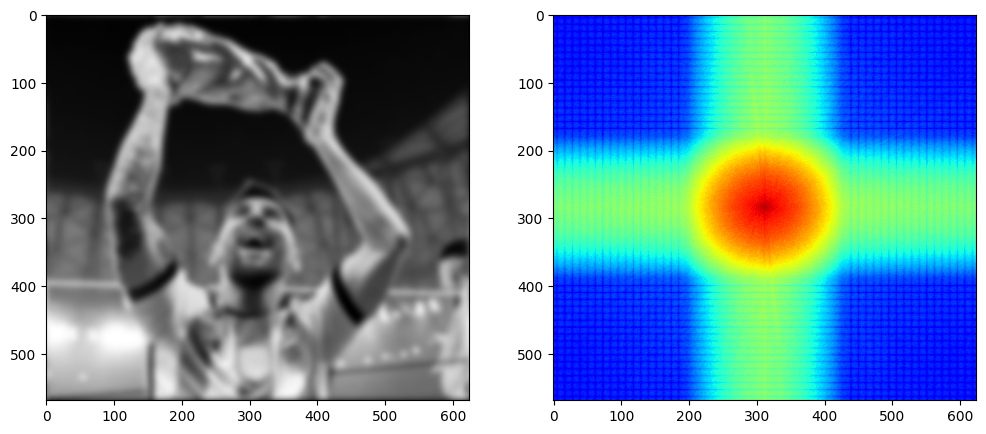

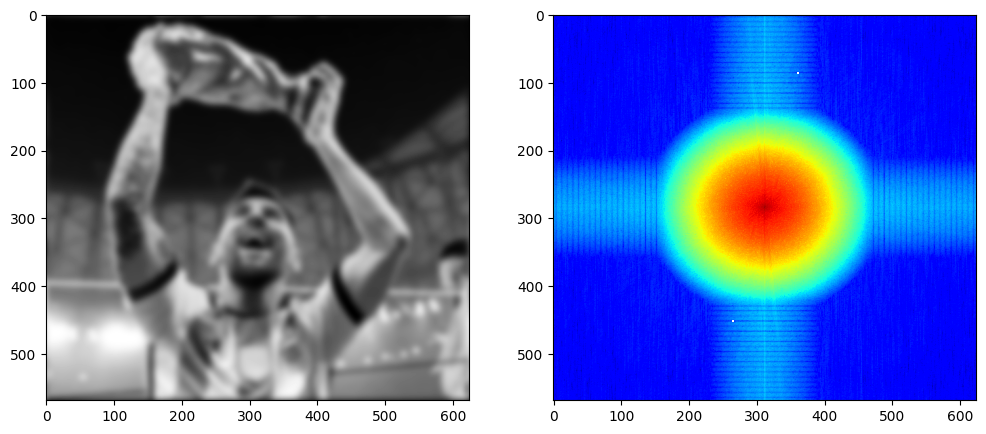

In [49]:
Filtrar_imagen(Messi, k_size=5, sigma=5)
Filtrar_imagen(Messi, k_size=15, sigma=5)
Filtrar_imagen(Messi, k_size=35, sigma=5)
Filtrar_imagen(Messi, k_size=55, sigma=5)
Filtrar_imagen(Messi, k_size=75, sigma=5)

## k_size Fijo

Metricas para k_size = 15 y sigma = 3
Metricas de FM:  0.003737438601234735
Metricas de Tenegrad:  771974729.2717481
Metricas de GLV:  4158.149845660232  -  4158.149845660225 

Metricas para k_size = 15 y sigma = 5
Metricas de FM:  0.0027573115226893785
Metricas de Tenegrad:  509906230.4973162
Metricas de GLV:  3976.8783107412773  -  3976.8783107412746 

Metricas para k_size = 15 y sigma = 7
Metricas de FM:  0.0025488936956423775
Metricas de Tenegrad:  457918933.566163
Metricas de GLV:  3920.428561602375  -  3920.4285616023753 

Metricas para k_size = 15 y sigma = 10
Metricas de FM:  0.0024249695822630797
Metricas de Tenegrad:  436777961.52691746
Metricas de GLV:  3890.4643096018067  -  3890.4643096018053 

Metricas para k_size = 15 y sigma = 15
Metricas de FM:  0.0023855391825514847
Metricas de Tenegrad:  427622751.6969158
Metricas de GLV:  3874.6437693762114  -  3874.643769376213 



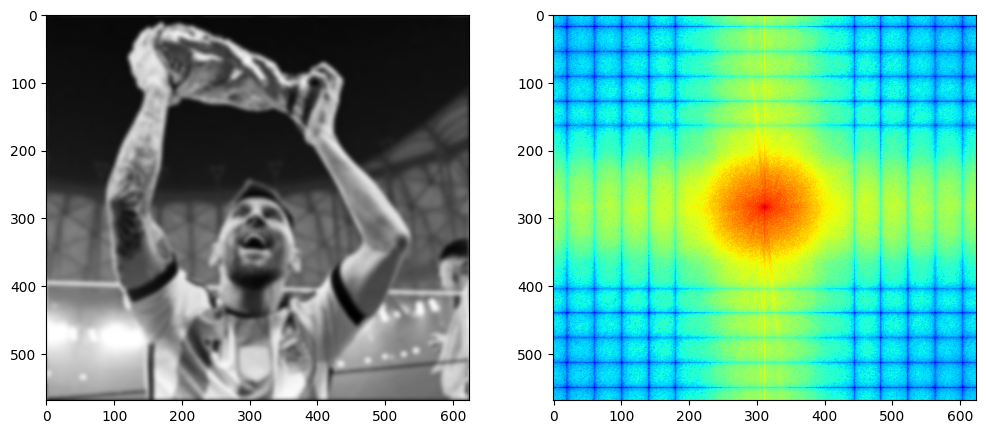

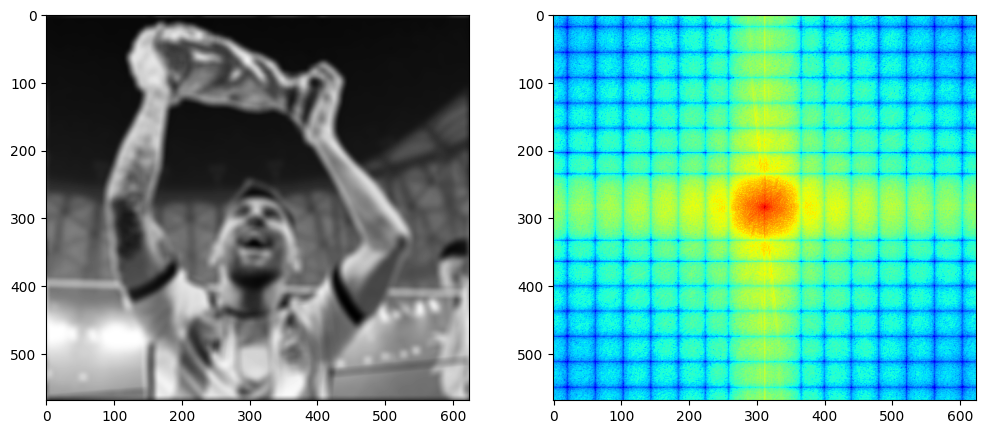

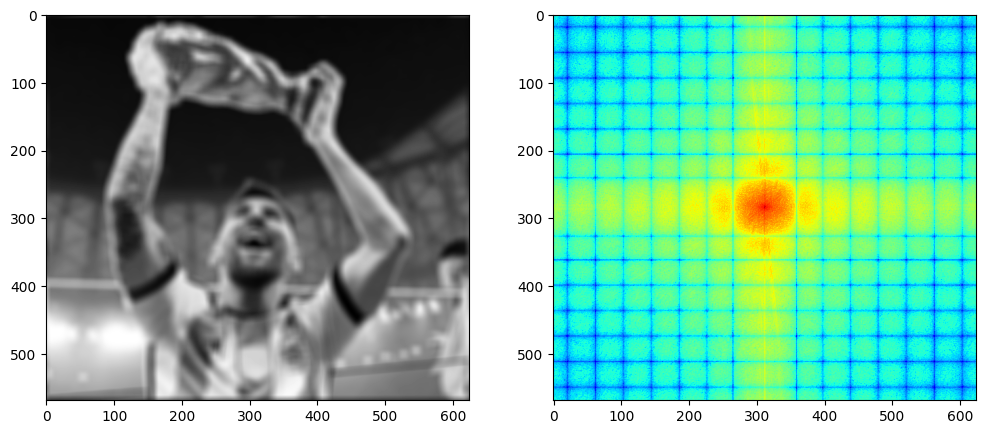

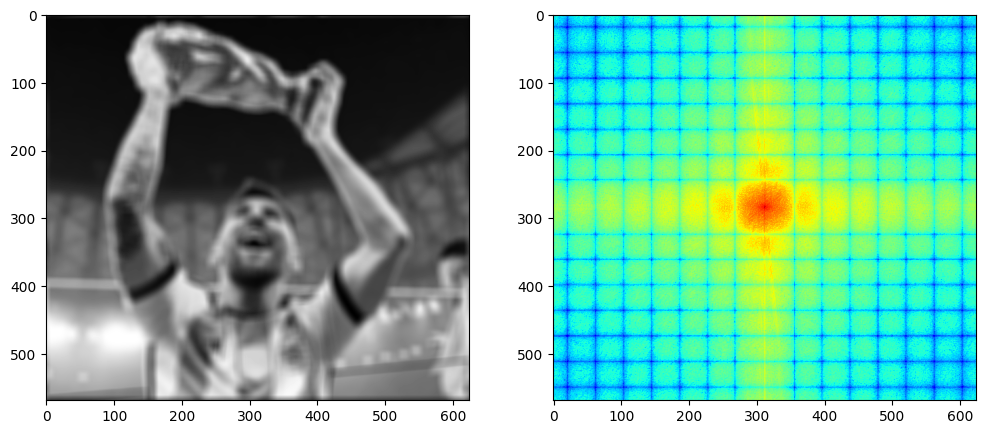

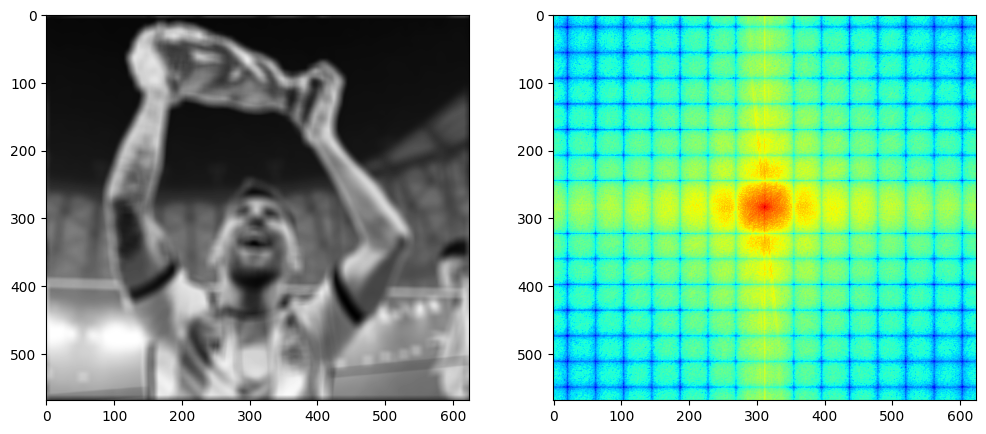

In [50]:
Filtrar_imagen(Messi, k_size=15, sigma=3)
Filtrar_imagen(Messi, k_size=15, sigma=5)
Filtrar_imagen(Messi, k_size=15, sigma=7)
Filtrar_imagen(Messi, k_size=15, sigma=10)
Filtrar_imagen(Messi, k_size=15, sigma=15)

## Conclusiones Punto 1

Las metricas y las imagenes graficadas muestran que aumentando el K_size y el Sigma el desenfoque también aumenta.

Sin embargo existe un punto en el que la imagen no puede filtrarse más debido a que ya no tiene componentes de alta frecuencia y las metricas resultan similares en valores grandes de K_size y Sigma

# Punto 2/3 - Comparación de imagenes utilizando filtrado por convolución

## Comparacion de imagenes

In [51]:
k_size = 17
sigma = 5

# Filtrado por Convolucion
Messi_conv = cv.GaussianBlur(Messi, ksize=(k_size, k_size), sigmaX=sigma)

# Filtrado espectral
kernel, fft = create_gauss_filter(569, 624, k_size, sigma)
fft_imagen_plt, Messi_espectral = Aplicar_filtro(Messi, fft)

In [52]:
print("Filtrado por convolucion: \n")
Metricas(Messi_conv, k_size, sigma)

print("Filtrado espectral: \n")
Metricas(Messi_espectral, k_size, sigma)

Filtrado por convolucion: 

Metricas para k_size = 17 y sigma = 5
Metricas de FM:  0.0026615519805326484
Metricas de Tenegrad:  411105836.0
Metricas de GLV:  4010.3422898314648  -  4010.3422898314698 

Filtrado espectral: 

Metricas para k_size = 17 y sigma = 5
Metricas de FM:  0.0025714253526204316
Metricas de Tenegrad:  451947185.973811
Metricas de GLV:  3919.837600198094  -  3919.8376001981 



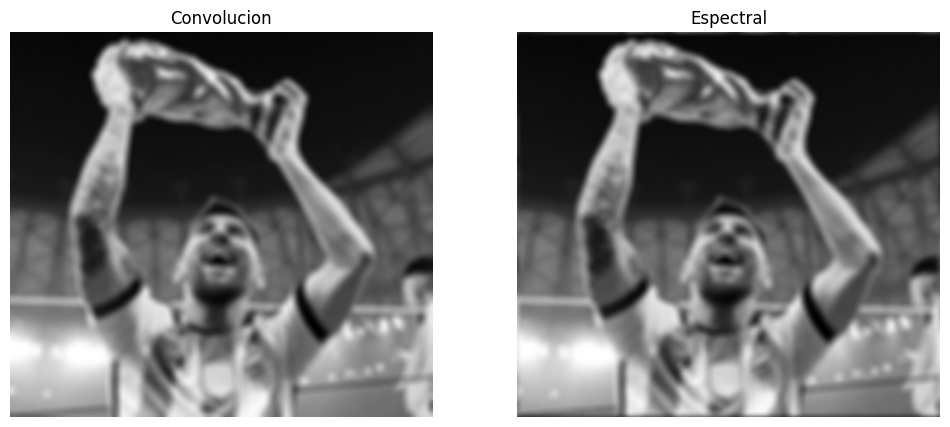

In [53]:
plt.figure(figsize=(12, 8)) 

# Subplot para la imagen original
plt.subplot(1, 2, 1)
plt.imshow(Messi_conv, cmap='gray')
plt.title('Convolucion')
plt.axis('off')

# Subplot para la imagen filtrada
plt.subplot(1, 2, 2)
plt.imshow(Messi_espectral, cmap='gray')
plt.title('Espectral')
plt.axis('off')

# Muestra las imágenes
plt.show()

## Comparacion de metricas

### Sigma Fijo

In [54]:
FM_conv = []
FM_espectral = []

Tenengrad_conv = []
Tenengrad_espectral = []

GLV_conv = []
GLV_espectral = []

k_values = []
sigma = 5
for k_size in range(1, 75, 2):
    k_values.append(k_size)
    
    # Filtrado por Convolucion
    Messi_conv = cv.GaussianBlur(Messi, ksize=(k_size, k_size), sigmaX=sigma)
    FM_conv.append(Image_Sharpness_Measure(Messi_conv))
    Tenengrad_conv.append(Tenengrad(Messi_conv))
    GLV_conv.append(Gray_level_variance(Messi_conv))
    

    # Filtrado espectral
    kernel, fft = create_gauss_filter(569, 624, k_size, sigma)
    fft_imagen_plt, Messi_espectral = Aplicar_filtro(Messi, fft)
    FM_espectral.append(Image_Sharpness_Measure(Messi_espectral))
    Tenengrad_espectral.append(Tenengrad(Messi_espectral))
    GLV_espectral.append(Gray_level_variance(Messi_espectral))

Metricas de FM:  0.009229529989635438
Metricas de Tenegrad:  5126557138.0
Metricas de GLV:  4894.820845061803  -  4894.820845061808 

Metricas de FM:  0.009229529989635438
Metricas de Tenegrad:  5126557137.999992
Metricas de GLV:  4894.820845061793  -  4894.820845061794 

Metricas de FM:  0.007888896399441216
Metricas de Tenegrad:  2975920710.0
Metricas de GLV:  4710.89004541672  -  4710.890045416728 

Metricas de FM:  0.007838200171240593
Metricas de Tenegrad:  3028411688.79977
Metricas de GLV:  4692.057249588721  -  4692.057249588723 

Metricas de FM:  0.006390541210400613
Metricas de Tenegrad:  1779083648.0
Metricas de GLV:  4549.919375809296  -  4549.919375809297 

Metricas de FM:  0.006334212067955478
Metricas de Tenegrad:  1860542203.1303937
Metricas de GLV:  4515.504004848288  -  4515.504004848284 

Metricas de FM:  0.005173831733585688
Metricas de Tenegrad:  1194972934.0
Metricas de GLV:  4414.0081121061785  -  4414.008112106171 

Metricas de FM:  0.00512876841962958
Metricas d

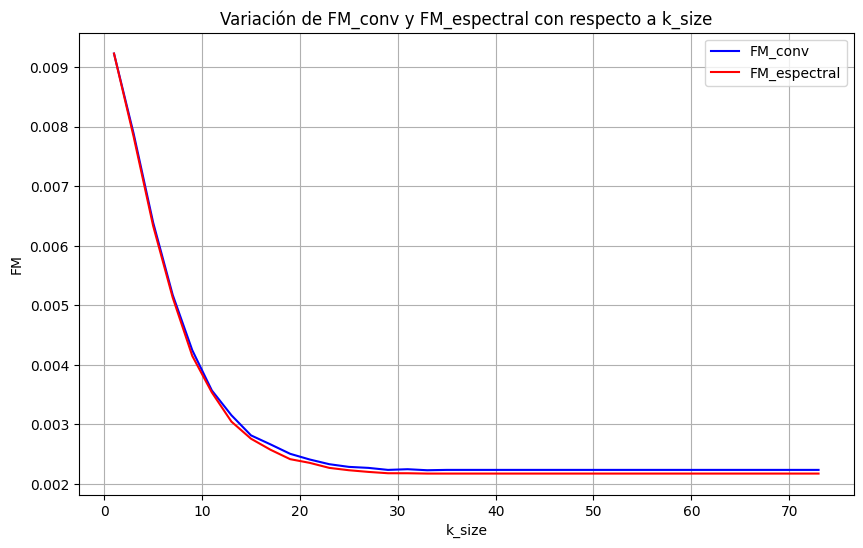

In [55]:
# Crear la gráfica
plt.figure(figsize=(10, 6))  # Tamaño de la figura

# Graficar FM_conv en azul
plt.plot(k_values, FM_conv, color='blue', label='FM_conv')

# Graficar FM_espectral en rojo
plt.plot(k_values, FM_espectral, color='red', label='FM_espectral')

# Configuración de la gráfica
plt.title('Variación de FM_conv y FM_espectral con respecto a k_size')
plt.xlabel('k_size')
plt.ylabel('FM')
plt.legend()  # Mostrar leyenda

# Mostrar la gráfica
plt.grid(True)
plt.show()

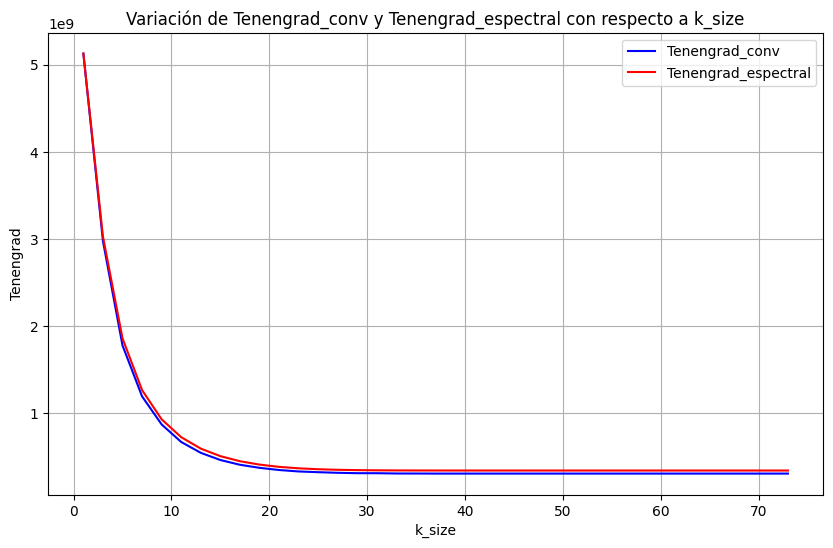

In [56]:
# Crear la gráfica
plt.figure(figsize=(10, 6))  # Tamaño de la figura

# Graficar FM_conv en azul
plt.plot(k_values, Tenengrad_conv, color='blue', label='Tenengrad_conv')

# Graficar FM_espectral en rojo
plt.plot(k_values, Tenengrad_espectral, color='red', label='Tenengrad_espectral')

# Configuración de la gráfica
plt.title('Variación de Tenengrad_conv y Tenengrad_espectral con respecto a k_size')
plt.xlabel('k_size')
plt.ylabel('Tenengrad')
plt.legend()  # Mostrar leyenda

# Mostrar la gráfica
plt.grid(True)
plt.show()

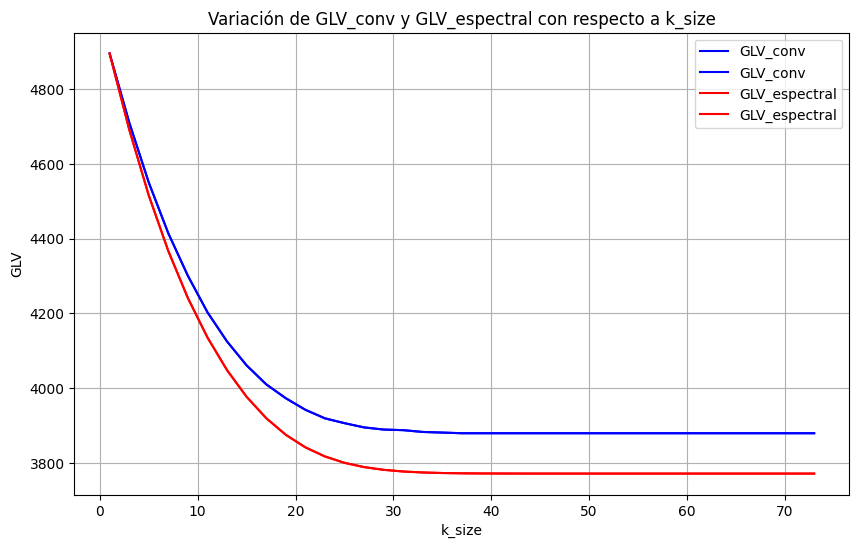

In [57]:
# Crear la gráfica
plt.figure(figsize=(10, 6))  # Tamaño de la figura

# Graficar FM_conv en azul
plt.plot(k_values, GLV_conv, color='blue', label='GLV_conv')

# Graficar FM_espectral en rojo
plt.plot(k_values, GLV_espectral, color='red', label='GLV_espectral')

# Configuración de la gráfica
plt.title('Variación de GLV_conv y GLV_espectral con respecto a k_size')
plt.xlabel('k_size')
plt.ylabel('GLV')
plt.legend()  # Mostrar leyenda

# Mostrar la gráfica
plt.grid(True)
plt.show()

### k_size fijo

In [60]:
FM_conv = []
FM_espectral = []

Tenengrad_conv = []
Tenengrad_espectral = []

GLV_conv = []
GLV_espectral = []

sigma_values = []
k_size = 19

for sigma in range(1, 75, 2):
    sigma_values.append(sigma)
    
    # Filtrado por Convolucion
    Messi_conv = cv.GaussianBlur(Messi, ksize=(k_size, k_size), sigmaX=sigma)
    FM_conv.append(Image_Sharpness_Measure(Messi_conv))
    Tenengrad_conv.append(Tenengrad(Messi_conv))
    GLV_conv.append(Gray_level_variance(Messi_conv))

    # Filtrado espectral
    kernel, fft = create_gauss_filter(569, 624, k_size, sigma)
    fft_imagen_plt, Messi_espectral = Aplicar_filtro(Messi, fft)
    FM_espectral.append(Image_Sharpness_Measure(Messi_espectral))
    Tenengrad_espectral.append(Tenengrad(Messi_espectral))
    GLV_espectral.append(Gray_level_variance(Messi_espectral))

Metricas de FM:  0.007421364517146591
Metricas de Tenegrad:  2619617392.0
Metricas de GLV:  4665.653507586651  -  4665.653507586654 

Metricas de FM:  0.00738756703167951
Metricas de Tenegrad:  2655283795.828395
Metricas de GLV:  4641.792791642852  -  4641.792791642849 

Metricas de FM:  0.0036529448875670316
Metricas de Tenegrad:  697802446.0
Metricas de GLV:  4206.738826934217  -  4206.738826934213 

Metricas de FM:  0.003624780316344464
Metricas de Tenegrad:  746330989.1615626
Metricas de GLV:  4138.864449974997  -  4138.864449974992 

Metricas de FM:  0.0025038303816862693
Metricas de Tenegrad:  376087808.0
Metricas de GLV:  3973.1765295987016  -  3973.1765295987043 

Metricas de FM:  0.0024137037537740524
Metricas de Tenegrad:  413032932.2496984
Metricas de GLV:  3875.3931295171337  -  3875.3931295171346 

Metricas de FM:  0.002098260556081294
Metricas de Tenegrad:  302078128.0
Metricas de GLV:  3882.8720230861004  -  3882.8720230861045 

Metricas de FM:  0.0020813618133477536
Met

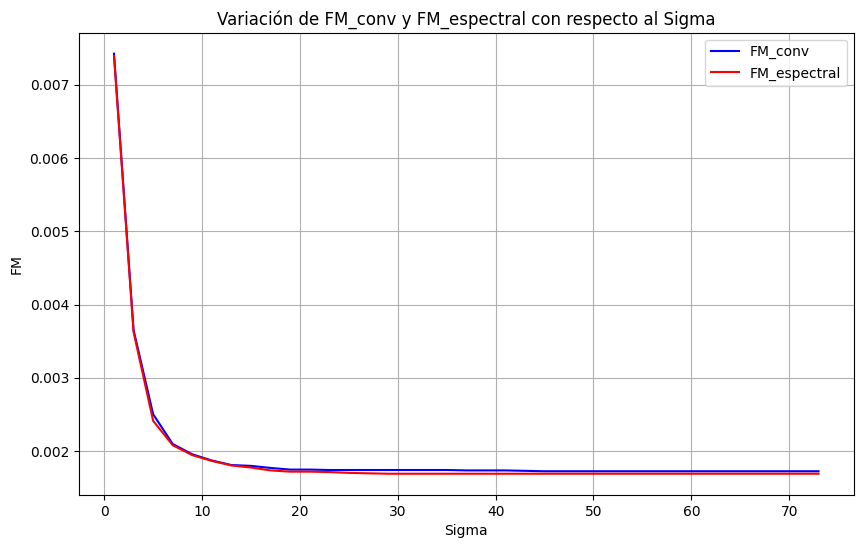

In [61]:
# Crear la gráfica
plt.figure(figsize=(10, 6))  # Tamaño de la figura

# Graficar FM_conv en azul
plt.plot(sigma_values, FM_conv, color='blue', label='FM_conv')

# Graficar FM_espectral en rojo
plt.plot(sigma_values, FM_espectral, color='red', label='FM_espectral')

# Configuración de la gráfica
plt.title('Variación de FM_conv y FM_espectral con respecto al Sigma')
plt.xlabel('Sigma')
plt.ylabel('FM')
plt.legend()  # Mostrar leyenda

# Mostrar la gráfica
plt.grid(True)
plt.show()

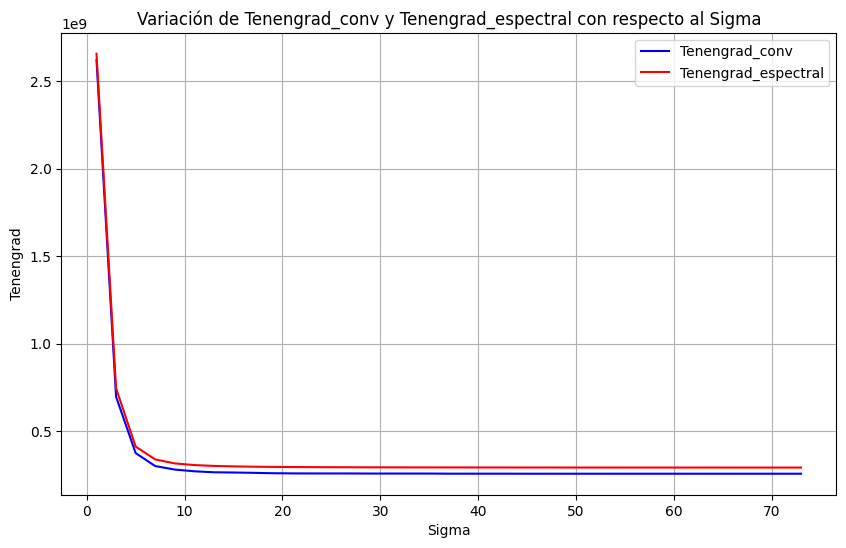

In [62]:
# Crear la gráfica
plt.figure(figsize=(10, 6))  # Tamaño de la figura

# Graficar FM_conv en azul
plt.plot(sigma_values, Tenengrad_conv, color='blue', label='Tenengrad_conv')

# Graficar FM_espectral en rojo
plt.plot(sigma_values, Tenengrad_espectral, color='red', label='Tenengrad_espectral')

# Configuración de la gráfica
plt.title('Variación de Tenengrad_conv y Tenengrad_espectral con respecto al Sigma')
plt.xlabel('Sigma')
plt.ylabel('Tenengrad')
plt.legend()  # Mostrar leyenda

# Mostrar la gráfica
plt.grid(True)
plt.show()

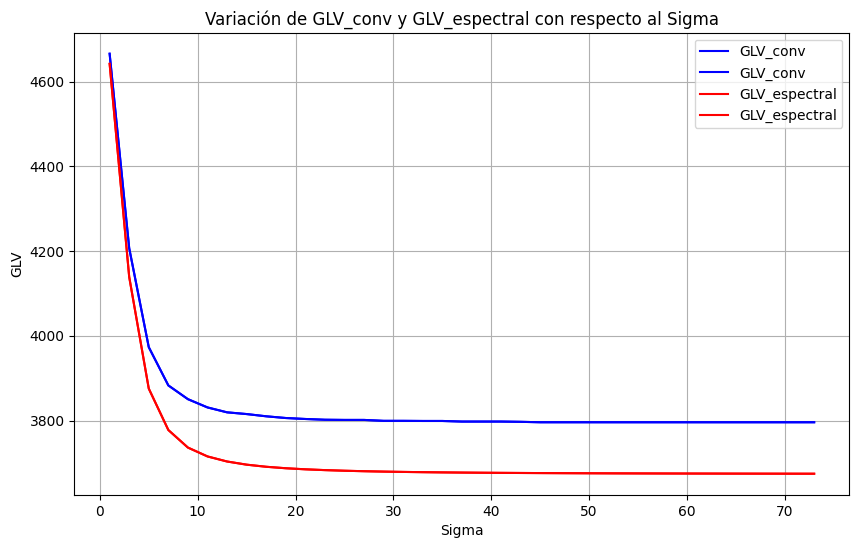

In [63]:
# Crear la gráfica
plt.figure(figsize=(10, 6))  # Tamaño de la figura

# Graficar FM_conv en azul
plt.plot(sigma_values, GLV_conv, color='blue', label='GLV_conv')

# Graficar FM_espectral en rojo
plt.plot(sigma_values, GLV_espectral, color='red', label='GLV_espectral')

# Configuración de la gráfica
plt.title('Variación de GLV_conv y GLV_espectral con respecto al Sigma')
plt.xlabel('Sigma')
plt.ylabel('GLV')
plt.legend()  # Mostrar leyenda

# Mostrar la gráfica
plt.grid(True)
plt.show()

### Conclusiones Punto 2/3

Los resultados de las métricas del filtrado espectral dan similares al del filtro por convolucion.

Se nota una pequeña diferencia utilizando la métrica GLV cuando la imagen se encuentra muy filtrada, esto puede deberse a que no es una de las mejores formas de medir nitidez en una imagen.